# Exercise 1: Designing an mRNA vaccine against SARS-CoV-2 variants

Gil Ayache 200358612

Joel Liurner 346243579

Benjamin Kramek 200208957

Agathe Benichou 345428312

### Prerequisites:

Step 1: Install BioPython Package

In [ ]:
!pip install -q biopython

     |████████████████████████████████| 2.3 MB 4.5 MB/s 


Step 2: Download the mRNA design of the Pfizer and Moderna vaccines

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd 'gdrive/My Drive/Ubiquitous Genomics/HW1/data/'
!ls

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1TtDvxh-tLpS8yfoSfrU6tQVO83L7UAIs/Ubiquitous Genomics/HW1/data
ba1_sequences.fasta  mRNA_design_032321.fasta.txt  wuhan_1_fasta.txt
ba2_sequences.fasta  NC_045512.2.fasta


In [ ]:
with open('mRNA_design_032321.fasta.txt') as f:
    lines = f.readlines()
print(lines)

['>Figure1_032321_Spike-encoding_contig_assembled_from_BioNTech/Pfizer_BNT-162b2_vaccine\n', 'GAGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACCCGCCACCATGTTCGTGTTCCTGGTGCTGCTGCC\n', 'TCTGGTGTCCAGCCAGTGTGTGAACCTGACCACCAGAACACAGCTGCCTCCAGCCTACACCAACAGCTTTACCAGAGGCG\n', 'TGTACTACCCCGACAAGGTGTTCAGATCCAGCGTGCTGCACTCTACCCAGGACCTGTTCCTGCCTTTCTTCAGCAACGTG\n', 'ACCTGGTTCCACGCCATCCACGTGTCCGGCACCAATGGCACCAAGAGATTCGACAACCCCGTGCTGCCCTTCAACGACGG\n', 'GGTGTACTTTGCCAGCACCGAGAAGTCCAACATCATCAGAGGCTGGATCTTCGGCACCACACTGGACAGCAAGACCCAGA\n', 'GCCTGCTGATCGTGAACAACGCCACCAACGTGGTCATCAAAGTGTGCGAGTTCCAGTTCTGCAACGACCCCTTCCTGGGC\n', 'GTCTACTACCACAAGAACAACAAGAGCTGGATGGAAAGCGAGTTCCGGGTGTACAGCAGCGCCAACAACTGCACCTTCGA\n', 'GTACGTGTCCCAGCCTTTCCTGATGGACCTGGAAGGCAAGCAGGGCAACTTCAAGAACCTGCGCGAGTTCGTGTTTAAGA\n', 'ACATCGACGGCTACTTCAAGATCTACAGCAAGCACACCCCTATCAACCTCGTGCGGGATCTGCCTCAGGGCTTCTCTGCT\n', 'CTGGAACCCCTGGTGGATCTGCCCATCGGCATCAACATCACCCGGTTTCAGACACTGCTGGCCCTGCACAGAAGCTACCT\n', 'GACACCTGGCGATAGCAGCAGCGGATGGACAGCTGGTGCCGCCGCT

Step 3: Download the sequence of “Wuhan” SARS-CoV-2 sequence from NCBI Genbank accession number NC_045512.2.

In [ ]:
# Imported as NC_045512.2.fasta in drive

Step 4: Download all complete sequences of SARS-CoV-2 BA.2 in a FASTA format.

In [ ]:
# Exists in drive as ba2_sequences.fasta

In [ ]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqUtils import GC
from math import inf
import sys
import numpy
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import random
from collections import Counter

### Questions

#### Basics

1. Create a function that takes mRNA as an input and returns the translated coding region (Hint 1: you need to find the initiation codon and the stop codon. Hint 2: use BioPython!).

In [ ]:
def generate_translated_coding_region(mRNASeq):

  start_codon = 'AUG'
  start_index = mRNASeq.find(start_codon)

  end_codons = ['UGA', 'UAG', 'UAA']
  end_codon = False
  end_index = start_index
  while not end_codon :
    codon = mRNASeq[end_index:end_index+3]
    if codon in end_codons:
      end_codon = codon
    end_index += 3

  # forcing to be within region
  translated_sequence = mRNASeq[start_index:end_index+3].translate(stop_symbol="@", to_stop=True, cds=False)
  return translated_sequence, start_index, end_index, end_codon

# load in datta from both vaccines
mRNA_sequence_dictionary = {}
for record in SeqIO.parse("mRNA_design_032321.fasta.txt", "fasta"):
  mRNA_sequence_dictionary[record.id] = {}
  mRNA_sequence_dictionary[record.id]['DNA Sequence'] = record.seq
  mRNA_sequence_dictionary[record.id]['RNA Sequence'] = record.seq.transcribe()

# for both vaccines, extract translated coding region 
for id, vaccine_components in mRNA_sequence_dictionary.items():
  translated_sequence, start_index, end_index, end_codon = generate_translated_coding_region(vaccine_components['RNA Sequence'])

  mRNA_sequence_dictionary[id]['Amino Acid Sequence'] = translated_sequence
  mRNA_sequence_dictionary[id]['Nucleotide Sequence'] = mRNA_sequence_dictionary[id]['RNA Sequence'][start_index:end_index+3]
  mRNA_sequence_dictionary[id]['Start Index'] = start_index
  mRNA_sequence_dictionary[id]['End Index'] = end_index
  mRNA_sequence_dictionary[id]['End Codon'] = end_codon

In [ ]:
print('Pfizer Vaccine details:')
print(mRNA_sequence_dictionary[list(mRNA_sequence_dictionary.keys())[0]])

print('Moderna Vaccine details:')
print(mRNA_sequence_dictionary[list(mRNA_sequence_dictionary.keys())[1]])

Pfizer Vaccine details:
{'DNA Sequence': Seq('GAGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACCCGCCACC...GCA'), 'RNA Sequence': Seq('GAGAAUAAACUAGUAUUCUUCUGGUCCCCACAGACUCAGAGAGAACCCGCCACC...GCA'), 'Amino Acid Sequence': Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), 'Nucleotide Sequence': Seq('AUGUUCGUGUUCCUGGUGCUGCUGCCUCUGGUGUCCAGCCAGUGUGUGAACCUG...UGA'), 'Start Index': 54, 'End Index': 3876, 'End Codon': Seq('UGA')}
Moderna Vaccine details:
{'DNA Sequence': Seq('GGGAAATAAGAGAGAAAAGAAGAGTAAGAAGAAATATAAGACCCCGGCGCCGCC...AAA'), 'RNA Sequence': Seq('GGGAAAUAAGAGAGAAAAGAAGAGUAAGAAGAAAUAUAAGACCCCGGCGCCGCC...AAA'), 'Amino Acid Sequence': Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), 'Nucleotide Sequence': Seq('AUGUUCGUGUUCCUGGUGCUGCUGCCCCUGGUGAGCAGCCAGUGCGUGAACCUG...UAA'), 'Start Index': 57, 'End Index': 3879, 'End Codon': Seq('UGA')}


2. For each vaccine:

  a. What’s the position of the initiation codon (“AUG”)?

  b. What’s the position of the termination codon? All positions should be reported as zero based

  c. What sequence did each company use for the stop codon?

  d. Please suggest another stop codon sequence.

  e. How would you call the area between the first nucleotide and the “AUG” site?
  
  f. How would you call the area between the termination codon and the last
nucleotide?

In [ ]:
def vaccine_analysis(id, vaccine_components):

  print(f"For vaccine: {id}") 
  print(f"The position of the initiation codon is: {vaccine_components['Start Index']}")

  print(f"The position of the termination codon is: {vaccine_components['End Index']}") 
  print(f"The sequence used for the stop codon is: {vaccine_components['End Codon']}")

  print("Another stop codon sequence could be: UAG or UAA")
  print("The area between the first nucleotide and the 'AUG' site is called 5UTR")
  print("The area between the termination codon and the last nucleotide is called 3UTR")
  print()

for id, vaccine_components in mRNA_sequence_dictionary.items():
  vaccine_analysis(id, vaccine_components)

For vaccine: Figure1_032321_Spike-encoding_contig_assembled_from_BioNTech/Pfizer_BNT-162b2_vaccine
The position of the initiation codon is: 54
The position of the termination codon is: 3876
The sequence used for the stop codon is: UGA
Another stop codon sequence could be: UAG or UAA
The area between the first nucleotide and the 'AUG' site is called 5UTR
The area between the termination codon and the last nucleotide is called 3UTR

For vaccine: Figure_2_32321_Spike-encoding_contig_assembled_from_Moderna_mRNA-1273_vaccine
The position of the initiation codon is: 57
The position of the termination codon is: 3879
The sequence used for the stop codon is: UGA
Another stop codon sequence could be: UAG or UAA
The area between the first nucleotide and the 'AUG' site is called 5UTR
The area between the termination codon and the last nucleotide is called 3UTR



3. Using your function, translate the coding area into protein. What’s the length of each coding sequence?

In [ ]:
# extract keys for pfizer and moderna
pfizer = list(mRNA_sequence_dictionary.keys())[0]
moderna = list(mRNA_sequence_dictionary.keys())[1]

# find length of vaccines
pfizer_length = mRNA_sequence_dictionary[pfizer]['End Index'] - mRNA_sequence_dictionary[pfizer]['Start Index'] 
pfizer_amino_acids = pfizer_length/3
moderna_length = mRNA_sequence_dictionary[moderna]['End Index'] - mRNA_sequence_dictionary[moderna]['Start Index'] 
moderna_amino_acids = moderna_length/3

print(f"The length of the Pfizer vaccine is {pfizer_length} nucleotides ({pfizer_amino_acids} amino acids)")
print(f"The length of the Moderna vaccine is {moderna_length} nucleotides ({moderna_amino_acids} amino acids)")

The length of the Pfizer vaccine is 3822 nucleotides (1274.0 amino acids)
The length of the Moderna vaccine is 3822 nucleotides (1274.0 amino acids)


4. Are the coding regions of the vaccines identical in the protein level?

In [ ]:
pfizer_translated_sequence = mRNA_sequence_dictionary[pfizer]['Amino Acid Sequence']
moderna_translated_sequence = mRNA_sequence_dictionary[moderna]['Amino Acid Sequence']

pfizer_translated_sequence == moderna_translated_sequence

True

5. Are the coding regions of the vaccines identical in the nucleotide level?

In [ ]:
pfizer_sequence = mRNA_sequence_dictionary[pfizer]['Nucleotide Sequence']
modern_sequence = mRNA_sequence_dictionary[moderna]['Nucleotide Sequence']

pfizer_sequence == modern_sequence

False

### Codon usage

6. Create a histogram of amino-acids usage for the Pfizer vaccine

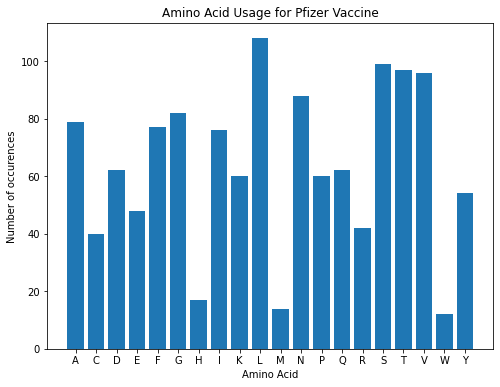

In [ ]:
pfizer_translated_sequence = mRNA_sequence_dictionary[pfizer]['Amino Acid Sequence']

amino_acids = numpy.array(pfizer_translated_sequence)
unique, counts = numpy.unique(amino_acids, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(unique, counts)
plt.title("Amino Acid Usage for Pfizer Vaccine")
plt.ylabel("Number of occurences")
plt.xlabel("Amino Acid")
plt.show()

7. Create the same histogram but color each codon within the amino-acid (i.e. create a
stacked histogram)

In [ ]:
pfizer_nucleotide_sequence = mRNA_sequence_dictionary[pfizer]['Nucleotide Sequence']

pfizer_amino_codon_dict = {}
nucleotide_index = 0
# iterate through the pfizer vaccine to see which codon each amino acid is associated with
for amino_acid in mRNA_sequence_dictionary[pfizer]['Amino Acid Sequence']:

  if not amino_acid in pfizer_amino_codon_dict.keys():
    pfizer_amino_codon_dict[amino_acid] = {}

  codon = str(pfizer_nucleotide_sequence[nucleotide_index:nucleotide_index+3])
  if codon in pfizer_amino_codon_dict[amino_acid].keys():
    pfizer_amino_codon_dict[amino_acid][codon] += 1
  else:
    pfizer_amino_codon_dict[amino_acid][codon] = 1
  nucleotide_index += 3

# plot graph of codon per amino acid
pfizer_amino_codon_df = pd.DataFrame(pfizer_amino_codon_dict)
stack_hist = pfizer_amino_codon_df.T
stack_hist = stack_hist.fillna(0)
fig = px.bar(stack_hist, x=stack_hist.index, y=stack_hist.columns, title="Stacked codons per Amino Acid")
fig.show()

### Comparison to the Wuhan strain:

8. What’s the length of the Wuhan strain genome?

In [ ]:
wuhan_dictionary = {}

print('Wuhan strain details:')
print(list(SeqIO.parse('NC_045512.2.fasta', 'fasta'))[0])

wuhan_dictionary['DNA Sequence'] = list(SeqIO.parse('NC_045512.2.fasta', 'fasta'))[0].seq
wuhan_dictionary['RNA Sequence'] = wuhan_dictionary['DNA Sequence'].transcribe()
print()
print(f"The length of the Wuhan strain genome is {len(wuhan_dictionary['DNA Sequence'])}")

Wuhan strain details:
ID: NC_045512.2
Name: NC_045512.2
Description: NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
Number of features: 0
Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA')

The length of the Wuhan strain genome is 29903


9. Report the nucleotide sequence of the Spike region of the Wuhan strain from the
initiation codon to the termination codon (hint: use the information in the NCBI website
about the starting and stopping position of Spike).

In [ ]:
# According to the website, the spike region from initiation codon to termination codon is 21563 to 25384
wuhan_dictionary['Spike Region DNA Sequence'] = wuhan_dictionary['DNA Sequence'][21563-1:25384]
wuhan_dictionary['Spike Region RNA Sequence'] = wuhan_dictionary['RNA Sequence'][21563-1:25384]
print('Wuhan Spike Region RNA Sequence:')
print(wuhan_dictionary['Spike Region RNA Sequence'])

Wuhan Spike Region RNA Sequence:
AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUUACAACCAGAACUCAAUUACCCCCUGCAUACACUAAUUCUUUCACACGUGGUGUUUAUUACCCUGACAAAGUUUUCAGAUCCUCAGUUUUACAUUCAACUCAGGACUUGUUCUUACCUUUCUUUUCCAAUGUUACUUGGUUCCAUGCUAUACAUGUCUCUGGGACCAAUGGUACUAAGAGGUUUGAUAACCCUGUCCUACCAUUUAAUGAUGGUGUUUAUUUUGCUUCCACUGAGAAGUCUAACAUAAUAAGAGGCUGGAUUUUUGGUACUACUUUAGAUUCGAAGACCCAGUCCCUACUUAUUGUUAAUAACGCUACUAAUGUUGUUAUUAAAGUCUGUGAAUUUCAAUUUUGUAAUGAUCCAUUUUUGGGUGUUUAUUACCACAAAAACAACAAAAGUUGGAUGGAAAGUGAGUUCAGAGUUUAUUCUAGUGCGAAUAAUUGCACUUUUGAAUAUGUCUCUCAGCCUUUUCUUAUGGACCUUGAAGGAAAACAGGGUAAUUUCAAAAAUCUUAGGGAAUUUGUGUUUAAGAAUAUUGAUGGUUAUUUUAAAAUAUAUUCUAAGCACACGCCUAUUAAUUUAGUGCGUGAUCUCCCUCAGGGUUUUUCGGCUUUAGAACCAUUGGUAGAUUUGCCAAUAGGUAUUAACAUCACUAGGUUUCAAACUUUACUUGCUUUACAUAGAAGUUAUUUGACUCCUGGUGAUUCUUCUUCAGGUUGGACAGCUGGUGCUGCAGCUUAUUAUGUGGGUUAUCUUCAACCUAGGACUUUUCUAUUAAAAUAUAAUGAAAAUGGAACCAUUACAGAUGCUGUAGACUGUGCACUUGACCCUCUCUCAGAAACAAAGUGUACGUUGAAAUCCUUCACUGUAGAAAAAGGAAUCUAUCAAACUUCUAACUUUAGAGUCCAACCAA

10. Report the GC content of the Spike region of the Wuhan strain and compare it to the GC
content of the Spike region of the Pfizer vaccine.

In [ ]:
wuhan_dictionary['GC Content of Spike Region'] = GC(wuhan_dictionary['Spike Region RNA Sequence'])
print(f"The GC content of the spike region of the Wuhan strain is {wuhan_dictionary['GC Content of Spike Region']}%")
print(f"The GC content of the spike region of the Pfizer vaccine is {GC(mRNA_sequence_dictionary[pfizer]['Nucleotide Sequence'])}%")

The GC content of the spike region of the Wuhan strain is 37.31030873888017%
The GC content of the spike region of the Pfizer vaccine is 56.967320261437905%


11. Translate the sequence into amino acids and report the sequence of the protein

In [ ]:
wuhan_dictionary['Spike Region Amino Acid Sequence'] = wuhan_dictionary['Spike Region RNA Sequence'].translate(stop_symbol="@", to_stop=True, cds=False)
print('Wuhan Spike Region Amino Acid Sequence:')
print(wuhan_dictionary['Spike Region Amino Acid Sequence'])

Wuhan Spike Region Amino Acid Sequence:
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALN

12. Compare between the Spike region of the Pfizer vaccine to the Spike of the Wuhan
strain in the protein level. Are there any differences and where?
a. Bonus: explain the differences!

In [ ]:
def compare_regions(region_a_name, region_a, region_b_name, region_b, to_subtract=0):
  print(region_a_name)
  print(region_a)
  print(region_b_name)
  print(region_b)

  if len(region_a) < len(region_b):
    shortest = region_a
  else: 
    shortest = region_b
  tmp = ""
  position_of_differences = []
  for i in range(len(shortest)):
    if region_a[i] == region_b[i]:
      tmp = tmp + " "
    else:
      tmp = tmp + "*"
      position_of_differences.append(i)

  print("Scroll to the right to spot differences")
  print(tmp)
  print(f"There are {len(position_of_differences)-to_subtract} differences at positions: {position_of_differences}")
  return position_of_differences, len(position_of_differences)

In [ ]:
pfizer_spike = mRNA_sequence_dictionary[pfizer]['Amino Acid Sequence']
wuhan_spike = wuhan_dictionary['Spike Region Amino Acid Sequence']

pos, count_diff = compare_regions('Pfizer', pfizer_spike, 'Wuhan Spike', wuhan_spike)

Pfizer
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQI

Yes, there are two amino acid differences between the Wuhan spike region and the Pfizer vaccine at positions 985 and 986.

13. For the amino acids that appear in the vaccine and the Wuhan strain, create a look-up
table that maps between the Wuhan strain codon to the Pfizer codon

In [ ]:
# pfizer amino acid M is 10x made by AUG and 14x made from AUC
# virus to vaccine lookup = {'AUG': {'AUG': 10, 'AUC': 14}}
virus_vaccine_lookup = {}
for i in range(0, len(wuhan_dictionary['Spike Region RNA Sequence']), 3): 
  virus_codon = str(wuhan_dictionary['Spike Region RNA Sequence'][i:i+3])

  if not virus_codon in virus_vaccine_lookup.keys():
    virus_vaccine_lookup[virus_codon] = {}
  
  vaccine_codon = str(mRNA_sequence_dictionary[pfizer]['Nucleotide Sequence'][i:i+3])

  if vaccine_codon in virus_vaccine_lookup[virus_codon].keys():
    virus_vaccine_lookup[virus_codon][vaccine_codon] += 1
  else:
    virus_vaccine_lookup[virus_codon][vaccine_codon] = 1
  
# for every codon in the wuhan spike region, which codon does pfzer choose for the same amino acid
for key in virus_vaccine_lookup.keys():
  translated_key = Seq(key).translate()
  inner_translated_keys = [Seq(inner_key).translate() for inner_key in virus_vaccine_lookup[key].keys()]
  #print(f"Amino acid ({translated_key}) for virus correlates to amino acid ({inner_translated_keys}) for vaccine")

14. Can you deduce any rule about the look-up table that Pfizer uses internally?
a. Bonus: explain the differences!

In [ ]:
virus_vaccine_lookup

{'AAA': {'AAA': 6, 'AAG': 31, 'CCU': 1},
 'AAC': {'AAC': 26, 'AAU': 8},
 'AAG': {'AAA': 3, 'AAG': 20},
 'AAU': {'AAC': 41, 'AAU': 13},
 'ACA': {'ACA': 13, 'ACC': 27},
 'ACC': {'ACA': 1, 'ACC': 9},
 'ACG': {'ACC': 3},
 'ACU': {'ACA': 20, 'ACC': 24},
 'AGA': {'AGA': 10, 'AGG': 1, 'CGG': 9},
 'AGC': {'AGC': 3, 'UCC': 2},
 'AGG': {'AGA': 3, 'CGC': 1, 'CGG': 6},
 'AGU': {'AGC': 15, 'UCU': 2},
 'AUA': {'AUC': 16, 'AUU': 2},
 'AUC': {'AUC': 12, 'AUU': 2},
 'AUG': {'AUG': 14},
 'AUU': {'AUC': 38, 'AUU': 6},
 'CAA': {'CAA': 4, 'CAG': 42},
 'CAC': {'CAC': 3, 'CAU': 1},
 'CAG': {'CAG': 16},
 'CAU': {'CAC': 12, 'CAU': 1},
 'CCA': {'CCC': 15, 'CCU': 10},
 'CCC': {'CCC': 3, 'CCU': 1},
 'CCU': {'CCA': 4, 'CCC': 8, 'CCU': 17},
 'CGC': {'CGG': 1},
 'CGG': {'AGA': 1, 'CGG': 1},
 'CGU': {'AGA': 7, 'CGG': 2},
 'CUA': {'CUG': 9},
 'CUC': {'CUG': 12},
 'CUG': {'CUG': 3},
 'CUU': {'CUG': 36},
 'GAA': {'GAA': 12, 'GAG': 22},
 'GAC': {'GAC': 12, 'GAU': 7},
 'GAG': {'GAA': 2, 'GAG': 12},
 'GAU': {'GAC': 32, 'GA

It seems that most of the codons in the virus were replaced in the vaccine with similar codons, but that are G and C 'heavy'. This would make sense of the higher GC content found in the Pfizer vaccine, than in the Wuhan spike region. 

For example:
*  AGG was mapped to CGG more than it was mapped to AGA: {'AGA': 3, 'CGC': 1, 'CGG': 6}
*  UUG was apped to CUG more than it was mapped to CUC: {'CUC': 2, 'CUG': 18}

A molecule with more GC content has more hydrogen bonds (compared to AT content), which makes it more stable and have a greater resistance to dentaturation. Given that DNA with more GC content has higher stability, the molecule would be more durable to withstand environmental changes (like temperature during transport).

### The Variants

15. The BA.2 genomes that you have are NOT aligned to the Wuhan strain.
Notice that a nucleotide 13th in the genome Wuhan strain corresponds to nucleotide 14th in the genome in your collection. So you cannot simply use positions from the Wuhan strain to find positions in your collection.
Unfortunately, the only information that you have about the BA.2 variant is based on the Wuhan coordinates. There are multiple strategies to identify the Spike region but using the same coordinates of Wuhan is the wrong strategy.

In [ ]:
# method to align records 
def align_records(variant_samples):
  variant_spike_records = {}
  for record in variant_samples:

    potential_variant = record.seq.transcribe()
    start_alignment = pairwise2.align.localms(potential_variant, wuhan_spike[0:20], 2, -1, -1, -1)
    start_index = start_alignment[0].start

    end_alignment = pairwise2.align.localms(potential_variant, wuhan_spike[-20:], 2, -1, -1, -1)
    end_index = end_alignment[0].end

    spike_sequence = potential_variant[start_index:end_index]
    variant_spike_records[record.id] = {'Start': start_index, 'End': end_index, 'Spike Sequence': spike_sequence}

  return variant_spike_records

In [ ]:
wuhan_spike = wuhan_dictionary['Spike Region RNA Sequence']

# random list of 20 samples from ba2 variant
random_ba2_samples = random.sample(list(SeqIO.parse('ba2_sequences.fasta', 'fasta')), 20)
ba2_spike_records = align_records(random_ba2_samples)
print(ba2_spike_records)

{'ON067002.1': {'Start': 21507, 'End': 25320, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'OM927130.1': {'Start': 21528, 'End': 25341, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'OM879613.1': {'Start': 21549, 'End': 25362, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'OM936482.2': {'Start': 21553, 'End': 25366, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'ON091078.1': {'Start': 21418, 'End': 25231, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'ON034478.1': {'Start': 21503, 'End': 25316, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'OM873836.1': {'Start': 21514, 'End': 25327, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'ON105655.1': {'Start': 21551, 'End': 25364, 'Spike Sequence': Seq('

In [ ]:
# method to find the length of all the sample variants
def find_spike_lengths(variant_name, variant_spike_records):
  print(f"For {variant_name} variant, here are the lengths of the spike regions:")
  spike_lengths = []
  for key in variant_spike_records.keys():
    record = variant_spike_records[key]
    spike_lengths.append(record['End'] - record['Start'])
  return spike_lengths

# method to extract a variant sample 
def extract_variant_sample(variant_spike_records, file_name, record=0):
  print()
  variant_full_sample = None
  random_record_id = list(variant_spike_records.keys())[record]
  for rec in list(SeqIO.parse(file_name, 'fasta')):
    if rec.name == random_record_id:
      variant_full_sample = rec
      break
  print('Here is the full record for the variant:')
  return variant_full_sample

In [ ]:
# find length of ba2 spike
spike_lengths = find_spike_lengths('ba2', ba2_spike_records)
print(spike_lengths)

# extract the full sample from original file
ba2_full_sample = extract_variant_sample(ba2_spike_records, 'ba2_sequences.fasta')
print(ba2_full_sample)

For ba2 variant, here are the lengths of the spike regions:
[3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813]

Here is the full record for the variant:
ID: ON067002.1
Name: ON067002.1
Description: ON067002.1 |Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/MA-Broad-CRSP_P433OG4WZ563OYTX/2022, complete genome
Number of features: 0
Seq('TCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...AAA')


From the NCBI database, there exists over 9000 complete sequences for the BA.2 variant. In order to identify the spike region for the variant, we decided that it would be more time efficient if we select only one of the entries and work with that.

The length of each of the randomly sampled variants are the same. 

16. Report all entries in your collection that you think match the BA.2 variant. Where were
they collected? Does it make sense?

In [ ]:
# method to find the location of variants
def find_collection_location(variant_name, file_name):
  print(f"For {variant_name} variant, here are the collection locations:")
  locations = []
  for record in SeqIO.parse(file_name, 'fasta'):
    try:
      location = record.description.split('/')[2]
      locations.append(location)
    except:
      continue
  print(Counter(locations))

In [ ]:
find_collection_location('ba2', 'ba2_sequences.fasta')

For ba2 variant, here are the collection locations:
Counter({'USA': 7657, 'BHR': 949, 'BGD': 43, 'SouthAfrica': 5, 'CHN': 5, 'IND': 4, 'AUT': 3, 'MMR': 2, 'MWI': 2, 'FRA': 2, 'DJI': 1, 'SZ-NIG-4-C67': 1, 'SZ-NIG-4-C117': 1, 'SZ-NIG-4-C118': 1, 'HKG': 1, 'DNK': 1})


Out of the 9000 entries in the collection of BA.2 variants, most of them were collected from the USA and then followed by Bahrain. It would have made more sense if South Africa had collected more entries, since that it where the variant was originally from. 

According to the WHOs weekly [Epidemiological Update from February 13th 2022](https://reliefweb.int/sites/reliefweb.int/files/resources/20220215_Weekly_Epi_Update_79.pdf), Bahrain and the US were a few of the countries where all variants were found. Perhaps given their national resources and abilties, this makes them more able to sequence the variants compared to other countries. 

17. Develop a method to extract the Spike sequence of one of the entries, translate, and
report the protein sequence (hint: the BA.2 spike is not very different than the Wuhan
strain and must start with AUG).

In [ ]:
def report_protein_sequence_ba(variant_full_sample, variant_spike_records):
  variant_dictionary = {}

  print(f"For entry {variant_full_sample.id}..")
  variant_dictionary['Entry ID'] = variant_full_sample.id
  variant_dictionary['DNA Sequence'] = variant_full_sample.seq
  
  variant_dictionary['Spike Region Start Index'] = variant_spike_records.get(variant_full_sample.id)['Start']
  variant_dictionary['Spike Region End Index'] = variant_spike_records.get(variant_full_sample.id)['End']
  spike_rna_seq = variant_spike_records.get(variant_full_sample.id)['Spike Sequence']
  variant_dictionary['Spike Region RNA Sequence'] =spike_rna_seq
  spike_protein_seq = spike_rna_seq.translate()
  variant_dictionary['Spike Region Amino Acid Sequence'] = spike_protein_seq

  print(f"The protein sequence for the spike region is: ")
  print(spike_protein_seq)

  return variant_dictionary

In [ ]:
# pass in randomly select spike records and full sample of one of those records
ba2_dictionary = report_protein_sequence_ba(ba2_full_sample, ba2_spike_records)
print()
print(ba2_dictionary)

For entry ON067002.1..
The protein sequence for the spike region is: 
MFVFLVLLPLVSSQCVNLITRTQSYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLGRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFAFKCYGVSPTKLNDLCFTNVYADSFVIRGNEVSQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYGFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGK

In [ ]:
ba2_spike_protein = ba2_dictionary['Spike Region Amino Acid Sequence']
if ba2_spike_protein.find('X') == -1:
  print("There are no unknown aminoacids in the BA.2 Spike Sample")

There are no unknown aminoacids in the BA.2 Spike Sample


18. Use everything you learned so far, including the look up table of Pfizer and the addition
of special nucleotides to design a South African mRNA vaccine. Don’t forget the add the
5’UTR and 3’UTR. Report the vaccine sequence.

In [ ]:
# Present both Wuhan and BA2 Spike region
wuhan_spike_protein = wuhan_dictionary['Spike Region Amino Acid Sequence']
ba2_spike_protein = ba2_dictionary['Spike Region Amino Acid Sequence']

pos, count_diff = compare_regions('BA.2 Spike', ba2_spike_protein, 'Wuhan Spike', wuhan_spike_protein)

BA.2 Spike
MFVFLVLLPLVSSQCVNLITRTQSYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLGRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFAFKCYGVSPTKLNDLCFTNVYADSFVIRGNEVSQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYGFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFGAISSVLNDILSRLDKVEAEVQ

When comparing the Wuhan and BA.2 spike region, we noticed around 1168 differences between the corresponding amino acids. However, after close observation around amino acid number 23 (where the word spot begins), we noticed that there are 3 missing amino acids when compared to the Wuhan spike. As a result, this causes a shift in the BA.2 spike that characterizes the new variant. 

In [ ]:
# Present Wuhan and new BA2 Spike region without those three missing amino acids
wuhan_spike_protein = wuhan_dictionary['Spike Region Amino Acid Sequence']
ba2_spike_protein = ba2_dictionary['Spike Region Amino Acid Sequence']
copy_ba2_protein = str(ba2_spike_protein)
copy_ba2_protein = copy_ba2_protein[0:23]+'---'+copy_ba2_protein[23:]

# compare regions for both spike regions
pos, count_diff = compare_regions('Wuhan Spike', wuhan_spike_protein, 'BA.2 Spike', copy_ba2_protein, to_subtract=3)

Wuhan Spike
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVE

After manually inserting the placer amino acids into the BA.2 spike region, we see that there are much fewer differences with the Wuhan spike region (28 differences). 

In [ ]:
wuhan_rna_spike = wuhan_dictionary['Spike Region RNA Sequence']

pfizer_rna_spike = mRNA_sequence_dictionary[pfizer]['RNA Sequence']
pfizer_start_index =mRNA_sequence_dictionary[pfizer]['Start Index']
pfizer_end_index =mRNA_sequence_dictionary[pfizer]['End Index']

ba2_rna_spike = ba2_dictionary['Spike Region RNA Sequence']

ba2_vaccine = ""
# -9 because wuhan is longer than ba2 by 9 nucleotides
for i in range(0, len(wuhan_rna_spike)-9, 3):
  
  # the three amino acids --- that don't exist in wuhan spike
  if i in [69, 72, 75]:
    continue

  # compare wuhan and ba2 codons
  else:
    wuhan_codon = wuhan_rna_spike[i:i+3]
    ba2_codon = ba2_rna_spike[i:i+3]

    # if they are the same, copy the vaccine nucleotides
    if wuhan_codon == ba2_codon: 
      # taking the pfizer start index into account
      pfizer_codon = pfizer_rna_spike[i+pfizer_start_index:i+pfizer_start_index+3]
      ba2_vaccine = ba2_vaccine + pfizer_codon

    else:
      # use virus vaccine lookup table to determine the best vac nucleotide
      if ba2_codon in virus_vaccine_lookup.keys():
        best_codon = max(virus_vaccine_lookup[ba2_codon], key=virus_vaccine_lookup[ba2_codon].get)
        ba2_vaccine = ba2_vaccine + best_codon
      else:
        #print(f"EXCEPTION: {ba2_codon}")
        # codon not in virus vaccine lookup
        if ba2_codon == 'CGA':
          best_codon = 'CGC'
          ba2_vaccine = ba2_vaccine + best_codon

# add nucleotides before starting index (initial sequence) 3’UTR
ba2_vaccine = pfizer_rna_spike[0:pfizer_start_index] + ba2_vaccine

# add nucleotides after end index (concluding sequence) 5’UTR
ba2_vaccine = ba2_vaccine + pfizer_rna_spike[pfizer_end_index:]

print('Our BA.2 vaccine is:')
print(ba2_vaccine)


Our BA.2 vaccine is:
GAGAAUAAACUAGUAUUCUUCUGGUCCCCACAGACUCAGAGAGAACCCGCCACCAUGUUCGUGUUCCUGGUGCUGCUGCCUCUGGUGUCCAGCCAGUGUGUGAACCUGAUCACCAGAACACAGAACAGCUUCACCAGAGGCGUGUACUACCCUGACAAGGUGUUCAGAAGCAGCGUGCUGCACAGCACCCAGGACCUGUUCCUGCCUUUCUUCAGCAACGUGACCUGGUUCCACGCCAUCCACGUGAGCGGAACCAACGGCACCAAGCGGUUCGACAACCCUGUGCUGCCCUUCAACGACGGCGUGUACUUCGCCAGCACCGAGAAGAGCAACAUCAUCAGAGGCUGGAUCUUCGGCACCACCCUGGACAGCAAGACCCAGAGCCUGCUGAUCGUGAACAACGCCACCAACGUGGUGAUCAAGGUGUGCGAGUUCCAGUUCUGCAACGACCCCUUCCUGGACGUGUACUACCACAAGAACAACAAGAGCUGGAUGGAGAGCGAGUUCAGAGUGUACAGCAGCGCCAACAACUGCACCUUCGAGUACGUGAGCCAGCCUUUCCUGAUGGACCUGGAGGGCAAGCAGGGCAACUUCAAGAACCUGCGGGAGUUCGUGUUCAAGAACAUCGACGGCUACUUCAAGAUCUACAGCAAGCACACCCCUAUCAACCUGGGAAGAGACCUGCCUCAGGGCUUCAGCGCCCUGGAGCCCCUGGUGGACCUGCCCAUCGGCAUCAACAUCACCCGGUUCCAGACCCUGCUGGCCCUGCACAGAAGCUACCUGACCCCUGGCGACAGCAGCAGCGGCUGGACCGCCGGCGCCGCCGCCUACUACGUGGGCUAUCUGCAGCCUCGGACCUUCCUGCUGAAGUACAACGAGAACGGCACCAUCACCGACGCCGUGGACUGCGCCCUGGACCCUCUGAGCGAGACCAAGUGCACCCUGAAGAGCUUCACCGUGGAGAAGGGCAUCUACCAGA

In [ ]:
print(f"The GC content of the spike region of the Pfizer vaccine is {GC(mRNA_sequence_dictionary[pfizer]['Nucleotide Sequence'])}%")
print(f"The GC content of the spike region of our BA.2 variant vaccine is {GC(ba2_vaccine)}%")

The GC content of the spike region of the Pfizer vaccine is 56.967320261437905%
The GC content of the spike region of our BA.2 variant vaccine is 60.57252826557614%


To create the vaccine for the BA.2 variant, we compared each codon in the Wuhan RNA sequence (skipping over the ones we filled in) and if the codon in Wuhan matched with the codon in BA.2 then we take the corresponding codon in the Pfizer vaccine. If the codon does not match, we choose the most common replaced codon in the virus-vaccine lookup table we created. 

19. Repeat the same process for the BA.1 genomes. How many amino-acid differences are
there between the genomes of BA.1 and BA.2?

The BA.1 variant has over 88,000 entires samplied in the collection found in NCBI. Due to the large size of the file and limited space in google drive, we decided to only download 200 of the most recent entries. 

In [ ]:
wuhan_spike = wuhan_dictionary['Spike Region RNA Sequence']

# random list of variants
random_ba1_samples = random.sample(list(SeqIO.parse('ba1_sequences.fasta', 'fasta')), 30)
ba1_spike_records = align_records(random_ba1_samples)
print(ba1_spike_records)

{'ON105019.1': {'Start': 21496, 'End': 25309, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'ON102651.1': {'Start': 21538, 'End': 25351, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'ON104793.1': {'Start': 21496, 'End': 25303, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'ON104812.1': {'Start': 21529, 'End': 25342, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'ON103114.1': {'Start': 21496, 'End': 25303, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'ON105378.1': {'Start': 21530, 'End': 25343, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'ON102421.1': {'Start': 21496, 'End': 25309, 'Spike Sequence': Seq('AUGUUUGUUUUUCUUGUUUUAUUGCCACUAGUCUCUAGUCAGUGUGUUAAUCUU...UAA')}, 'ON102182.1': {'Start': 21529, 'End': 25342, 'Spike Sequence': Seq('

In [ ]:
# find length of ba2 spike
spike_lengths = find_spike_lengths('ba1', ba1_spike_records)
print("spike lengths", spike_lengths)

most_frequent_length = max(spike_lengths, key=spike_lengths.count)
print(f"The most frequent spike length is: {most_frequent_length}\n")

# extract the full sample from original file
# ba1_full_sample = extract_variant_sample(ba1_spike_records, 'ba1_sequences.fasta')
# print(ba1_full_sample)

For ba1 variant, here are the lengths of the spike regions:
spike lengths [3813, 3813, 3807, 3813, 3807, 3813, 3813, 3813, 3807, 3813, 3804, 3813, 3813, 3807, 3813, 3813, 3813, 3804, 3813, 3813, 3807, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813, 3813]
The most frequent spike length is: 3813



In [ ]:
# Find and extract complete sample with no unknown aminoacids
for i in range(len(spike_lengths)):
  if spike_lengths[i] == most_frequent_length:
    ba1_full_sample = extract_variant_sample(ba1_spike_records, 'ba1_sequences.fasta', i)
    amino_sequence = ba1_full_sample.translate()
    if str(amino_sequence).find('X') == -1:
      print("Record ", i, ":", str(amino_sequence))
      print("There are no unknown (X) aminoacids in the BA.1 Spike Sample")
      break

print()
print()
print("Chosen sample sequence:")
print(ba1_full_sample)


Here is the full record for the variant:
Record  0 : ID: <unknown id>
Name: <unknown name>
Description: <unknown description>
Number of features: 0
/molecule_type=protein
Seq('RSVL*TNFKICVAVTRLHA*CTHAV*LITNYCR*QDTSNSSIFCRLLTVSSVLQ...SAI')
There are no unknown (X) aminoacids in the BA.1 Spike Sample


Chosen sample sequence:
ID: ON105019.1
Name: ON105019.1
Description: ON105019.1 |Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/CO-CDPHE-2103041685/2022, complete genome
Number of features: 0
Seq('AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCAT...TCC')


/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:2983: BiopythonWarning:

Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.



In [ ]:
find_collection_location('ba1', 'ba1_sequences.fasta')

For ba1 variant, here are the collection locations:
Counter({'USA': 191, 'BHR': 9})


In [ ]:
# pass in randomly select spike records and full sample of one of those records
ba1_dictionary = report_protein_sequence_ba(ba1_full_sample, ba1_spike_records)
print()
print(ba1_dictionary)

For entry ON105019.1..
The protein sequence for the spike region is: 
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHVISGTNGTKRFDNPVLPFNDGVYFASIEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPIIVREPEDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLKGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFKGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGK

In [ ]:
# Present both Wuhan and BA1 Spike region
wuhan_spike_protein = wuhan_dictionary['Spike Region Amino Acid Sequence']
ba1_spike_protein = ba1_dictionary['Spike Region Amino Acid Sequence']

# compare regions for both spike regions
pos, count_diff = compare_regions('BA.1 Spike', ba1_spike_protein, 'Wuhan Spike', wuhan_spike_protein)

BA.1 Spike
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHVISGTNGTKRFDNPVLPFNDGVYFASIEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPIIVREPEDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLKGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFKGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFGAISSVLNDIFSRLDKVEAEVQ

In [ ]:
ba1_spike_protein = ba1_dictionary['Spike Region Amino Acid Sequence']
copy_ba1_protein = str(ba1_spike_protein)
copy_ba1_protein = copy_ba1_protein[0:68]+'--'+copy_ba1_protein[68:]
copy_ba1_protein = copy_ba1_protein[0:142]+'---'+copy_ba1_protein[142:]

copy_wuhan__protein = str(wuhan_spike_protein)
copy_wuhan__protein = copy_wuhan__protein[0:211]+'--'+copy_wuhan__protein[211:]

pos, count_diff = compare_regions('Wuhan Spike', copy_wuhan__protein,'BA.1 Spike', copy_ba1_protein, to_subtract=5)

Wuhan Spike
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDK

When comparing the original Wuhan spike region with the BA.1 region, there are 1130 differences. However, adding 5 amino acid fillers to two sections of the BA.1 spike sequence shows that there are actually much less differences than that.

In [ ]:
wuhan_rna_spike = wuhan_dictionary['Spike Region RNA Sequence']

pfizer_rna_spike = mRNA_sequence_dictionary[pfizer]['RNA Sequence']
pfizer_start_index =mRNA_sequence_dictionary[pfizer]['Start Index']
pfizer_end_index =mRNA_sequence_dictionary[pfizer]['End Index']

ba1_rna_spike = ba1_dictionary['Spike Region RNA Sequence']

ba1_vaccine = ""
# -9 because wuhan is longer than ba2 by 9 nucleotides
for i in range(0, len(wuhan_rna_spike), 3):
  
  # the amino acids --- that don't exist in wuhan spike
  if i in [68*3, 69*3, 142*3, 143*3, 144*3, 212*3]:
    continue

  # compare wuhan and ba1 codons
  else:
    wuhan_codon = wuhan_rna_spike[i:i+3]
    ba1_codon = ba1_rna_spike[i:i+3]

    # if they are the same, copy the vaccine nucleotides
    if wuhan_codon == ba1_codon: 
      # taking the pfizer start index into account
      pfizer_codon = pfizer_rna_spike[i+pfizer_start_index:i+pfizer_start_index+3]
      ba1_vaccine = ba1_vaccine + pfizer_codon

    else:
      # use virus vaccine lookup table to determine the best vac nucleotide
      if ba1_codon in virus_vaccine_lookup.keys():
        best_codon = max(virus_vaccine_lookup[ba1_codon], key=virus_vaccine_lookup[ba1_codon].get)
        ba1_vaccine = ba1_vaccine + best_codon
      else:
        #print(f"EXCEPTION: {ba1_codon}")
        # codon not in virus vaccine lookup
        if ba1_codon == 'CGA':
          best_codon = 'CGC'
          ba1_vaccine = ba1_vaccine + best_codon

# add nucleotides before starting index (initial sequence)
ba1_vaccine = pfizer_rna_spike[0:pfizer_start_index] + ba1_vaccine

# add nucleotides after end index (concluding sequence)
ba1_vaccine = ba1_vaccine + pfizer_rna_spike[pfizer_end_index:]

print('Our BA.1 vaccine is:')
print(ba1_vaccine)

Our BA.1 vaccine is:
GAGAAUAAACUAGUAUUCUUCUGGUCCCCACAGACUCAGAGAGAACCCGCCACCAUGUUCGUGUUCCUGGUGCUGCUGCCUCUGGUGUCCAGCCAGUGUGUGAACCUGACCACCAGAACACAGCUGCCUCCAGCCUACACCAACAGCUUUACCAGAGGCGUGUACUACCCCGACAAGGUGUUCAGAUCCAGCGUGCUGCACUCUACCCAGGACCUGUUCCUGCCUUUCUUCAGCAACGUGACCUGGUUCCACGUGAUCACCAACGGCACCAAGCGGUUCGACAACCCUGUGCUGCCCUUCAACGACGGCGUGUACUUCGCCAGCAUCGAGAAGAGCAACAUCAUCAGAGGCUGGAUCUUCGGCACCACCCUGGACAGCAAGACCCAGAGCCUGCUGAUCGUGAACAACGCCACCAACGUGGUGAUCAAGGUGUGCGAGUUCCAGUUCUGCAACGACCCCUUCCUGGACCACAAGAGCUGGAUGGAGAGCGAGUUCAGAGUGUACAGCAGCGCCAACAACUGCACCUUCGAGUACGUGAGCCAGCCUUUCCUGAUGGACCUGGAGGGCAAGCAGGGCAACUUCAAGAACCUGCGGGAGUUCGUGUUCAAGAACAUCGACGGCUACUUCAAGAUCUACAGCAAGCACACCCCUAUCAUCGUGAGAGAGCCCGAGGACCCUCAGGGCUUCAGCGCCCUGGAGCCCCUGGUGGACCUGCCCAUCGGCAUCAACAUCACCCGGUUCCAGACCCUGCUGGCCCUGCACAGAAGCUACCUGACCCCUGGCGACAGCAGCAGCGGCUGGACCGCCGGCGCCGCCGCCUACUACGUGGGCUAUCUGCAGCCUCGGACCUUCCUGCUGAAGUACAACGAGAACGGCACCAUCACCGACGCCGUGGACUGCGCCCUGGACCCUCUGAGCGAGACCAAGUGCACCCUGAAGAGCUUCACCGUGGAGAAGGGCAUCUACCAGACCAGCAACU

To create the BA.1 vaccine, we used the same strategy as the BA.2.

Finally, we will analyze the difference between the genomes of BA.1 and BA.2 spikes

In [ ]:
# compare how many amino-acid differences are there between the genomes of BA.1 and BA.2?
ba1_amino_seq = ba1_dictionary['Spike Region Amino Acid Sequence']
ba2_amino_seq = ba2_dictionary['Spike Region Amino Acid Sequence']

compare_regions('BA.1 Variant', ba1_amino_seq, 'BA.2 Variant', ba2_amino_seq)
print()

BA.1 Variant
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHVISGTNGTKRFDNPVLPFNDGVYFASIEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPIIVREPEDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLKGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFKGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFGAISSVLNDIFSRLDKVEAE

In [ ]:
copy_ba1_protein = str(ba1_amino_seq)
copy_ba2_protein = str(ba2_amino_seq)

copy_ba2_protein = copy_ba2_protein[0:23]+'///'+copy_ba2_protein[23:]

copy_ba1_protein = copy_ba1_protein[0:68]+'--'+copy_ba1_protein[68:]
copy_ba1_protein = copy_ba1_protein[0:142]+'---'+copy_ba1_protein[142:]

copy_ba2_protein = copy_ba2_protein[0:214]+'//'+copy_ba2_protein[214:]

pos, count_dif = compare_regions('BA.1 Variant', copy_ba1_protein, 'BA.2 Variant', copy_ba2_protein)

BA.1 Variant
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHVI--SGTNGTKRFDNPVLPFNDGVYFASIEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLD---HKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPIIVREPEDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLKGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFKGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFGAISSVLNDIFSRLD